In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [0]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteKYBDL6/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [0]:
metadata.features["label"].int2str

for image,label in raw_train.take(2):
  print(image.shape)

(262, 350, 3)
(409, 336, 3)


In [0]:
IMAGE_SIZE=160

def format_image(image,label):
  image=tf.cast(image,tf.float32)
  image=(image-127.5)/127.5
  image=tf.image.resize(image,(IMAGE_SIZE,IMAGE_SIZE))
  return image,label

In [0]:
train=raw_train.map(format_image)
validation = raw_validation.map(format_image)
test = raw_test.map(format_image)

In [0]:
BATCH_SIZE=32
BUFFER_SIZE=1000

train_batches=train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches=validation.batch(BATCH_SIZE)
test_batches=test.batch(BATCH_SIZE)

test shape in train batch

In [0]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [0]:
IMAGE_SHAPE=(IMAGE_SIZE,IMAGE_SIZE,3)

base_model=keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE,
                     include_top=False,
                     weights="imagenet")

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
feature_batch=base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [0]:
base_model.trainable=False

In [0]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
global_average_layer=keras.layers.GlobalAveragePooling2D()
feature_batch_average=global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([32, 1280])

In [0]:
prediction_layer=keras.layers.Dense(1)

In [0]:
model=keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),
       loss=keras.losses.BinaryCrossentropy(from_logits=True),
       metrics=["accuracy"])

In [0]:
epochs=3
validation_steps=20

history=model.fit(train_batches,
         epochs=epochs,
         validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 81s 139ms/step - loss: 0.2170 - accuracy: 0.9046 - val_loss: 0.0977 - val_accuracy: 0.9600
Epoch 2/3
582/582 [==============================] - 74s 127ms/step - loss: 0.0737 - accuracy: 0.9739 - val_loss: 0.0700 - val_accuracy: 0.9721
Epoch 3/3
582/582 [==============================] - 76s 131ms/step - loss: 0.0589 - accuracy: 0.9791 - val_loss: 0.0608 - val_accuracy: 0.9751


NameError: ignored

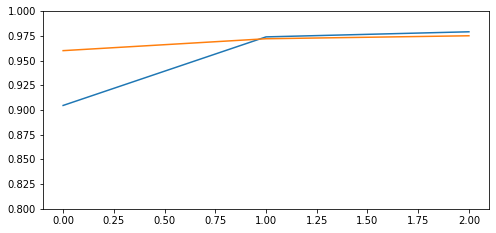

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()